# Data Exploration (Part VII - Lat Long Visualization)
## Review
In the last 2 posts, we reviewed (largely using Spark and Spark SQL (very handy)) all of the interesting fields. All of them except latitude and longitude. I ended the last post puzzled about how to actually plot this many points (5 million points!). Spark didn't have anything to do this, so I had to look elsewhere. The problem here is my whole exercise is to leverage _**distributed computing**_, but at this point, my definition of distributed computing has been... exclusively _**Spark**_. So I lied a bit, but that's only because I'm stupid, lazy, and _**don't**_ want to set up some distributed graphing software and manually configure a cluster across machines.

So, if _**Spark**_ won't work... what can we do? After a few google searches, I've come across a library called _**[datashader](https://github.com/bokeh/datashader)**_. Datashader claims to be able to make plots such as:

<img src="https://github.com/bokeh/datashader/raw/master/docs/images/nyc_races.jpg" width="700">

Lo and behold... that's pretty much what I'm looking for... A map of NYC! In the map above, the folks at datashader have mapped out the most prominent races according to the NYC census data. I feel like that's pretty much what I want, except the most prominent race becomes the prominent type of crime, or by the most prominent seriousness of a crime (violation, misdemeanor, felony).

Man... now I feel like a super basic data geek who thinks they're cutting edge because they're working with NYC data...

<img src="https://booktrib.com/wp-content/uploads/2015/10/basic-bitch.jpg" width="400">

The worst part? It took me 12 posts to realize it. Oh well, onward we move.

## Datashader
Here's a tutorial of datashader that honestly outputs some breathtaking visualizations.

[![IMAGE ALT TEXT](http://img.youtube.com/vi/fB3cUrwxMVY/0.jpg)](http://www.youtube.com/watch?v=fB3cUrwxMVY "Video Title")

Watching this video actually gives an interesting perspective on big data plotting as well. They approached datashader with a big data motivation, but not in the compute sense... more in the art of visualization sense. Their reasoning is that, simply plotting like a million points in a small area (a common example they use is thinking of how many data points is packed into each pixel on screen) will yield perception and accuracy problems.

[This post by the folks at Continuum](https://anaconda.org/jbednar/plotting_pitfalls/notebook?version=2016.11.11.1140) (who created datashader) shows some of the pitfalls of plotting a ton of data. Their argument is that, if any of these 6 pitfalls occur, the visualization may _**literally be lying to you**_.

The first one they talk about is _**overplotting**_. This is something I run into all the time and have used the alpha / opacity plotting parameter to solve in the past. Overplotting is when we have 2 classes identified by different colors plotted on the same chart. Let's say one group is plotted with blue, and the other is plotting in red:

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/29_overplotting.png)

We can see, depending on the order in which we plot the points actually matter. If we plot red first, then blue, we get image _**C**_ which masks many of the red points... we simply don't know if the red is there because we cannot see the bottom layer of the plot! Image _**D**_ is just the opposite - we can infer that there are blue points, and we may have already been biased looking at these sets of photos because we already know the true state of the data, but if we were looking at D for the first time we may not have been able to tell if the blue dots really exist!

This is when I'd play around with the alpha, or opacity of the dots to make the visualization a bit more truthful:

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/30_oversaturation.png)

Even here, we see that it's not perfect as there still is a difference between C and D. The datashader documentation then goes on to state that having to tweak the opacity and the dot sizes (see below with same opacity, but smaller dots)

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/31_oversaturation_small_dots.png)

makes the visualization process much slower and takes away the focus from what we're actually trying to do! It goes on to describe 4 more pitfalls that could occur when visualization the data, and continues to make the point that

> _**For big data, you don't know when the viz is lying**_

This comes from datashader's definition of big data that is

> _**Data is big when you can't make any inferences from any single point of data**_

This implies that the data is so granular (a single incident at a single lat long) that you're not meant to be able to infer any overall conclusions from a single data point, and going through every single point is an inefficient (and in all likelihood impossible) task because of pure volume. In a case like this, _**all you can rely on is the visualization**_, and if the visualization is incorrect, you don't have any QA tools to notice, so it's best to use the right theory from the get go.

When I tried to build a heatmap from the [Edmonton Property Assessment data](https://strikingmoose.com/2017/07/31/building-a-regression-model-k-nn/), the method I tried was to build a regression model that predicts an assessment value for each lat long value / range. In K-NN, we can infer lat / longs which do not have a property assessment tied to them by taking a look at those around them. In essence, we build a gradient across the lats and longs to communicate the predicted assessment value. After doing that, my visualization consisted of a set of predictions on _**a grid of inputs across edmonton**_ to ensure I have every area covered.

In this example, what I'd like to visualize is the _**volume of incidents**_, which I have inherently in the data, so I don't have to do anything fancy with predictive models. However, I still face all the problems that datashader has laid out. What datashader does is similar to what I had done in the [Edmonton Property Assessment](https://strikingmoose.com/2017/07/31/building-a-regression-model-k-nn/) post in that
1. It represents each pixel of the screen is represented by a value, not solely represented by the data points contributing to that pixel
2. \#1 is true because the value is represented by an _**overall model**_ that has the context of _**the entire dataset**_, not just the pixel in question

In datashader's example, if we set an alpha to 0.1, we are indicating that 10 points lying on top of each other will achieve _**full saturation**_. If, in our data, we only have points that are either not overlapping (singular points), or they overlap by 50 points at a time, it would be very difficult to create a plot that can show off this contrast well because anything over 10 points at a time will achieve full saturation! Anything between 10 and 50 points overlapping will look the same to the user. That's what happens when we don't generalize our data to some type of heatmap or model. This is where datashader's real advantage comes in, because datashader allows you to easily map your own model without having to go through the trouble that I went through in the [Edmonton Property Assessment](https://strikingmoose.com/2017/07/31/building-a-regression-model-k-nn/) project. Granted, I don't know if datashader can perform regression, but it's got a lot of great gradients (e.g. using log instead of linear) for our specific purpose, analying volumes of points in a region where each point is weighted the same!

## But Wait...
But wait... what happened to the whole thing about not being able to use Spark anymore? I thought we were trying to leverage distributed computing for this project? I agree, I am being a bit lazy here in dropping distributed computing altogether in this plot, but in the datashader video above, the guy plots _**ONE BILLION POINTS**_, and he does it on his Mac which I assume has no more than 32GB RAM (I'm probably wrong). If I think about it objectively, the inputs of a map are simply latitude and longitudes. The dataset is 1.3 GB, but the lats and longs probably only account for like 1/50th of the entire file size! Lat / longs are bounded by however many significant digits of the lat / long itself. A latitude like 53.631611 will always only take 9 bytes to represent, whereas a text description field is often much longer and variable. Given that there's about 35 rows of data in our parquet dataframe, lat / longs accounting for 1/50th of the file size isn't so farfetched to me! That brings down the file size to 30 MB. Let's say our own laptop had 32 GB memory, we could handle over _**1 TB**_ of just latitude and longitude data in memory.

There are different solutions for everything, and perhaps this one is the path of least resistance for mapping functionality!

## Back To Datashader
Let's try to import the dataset into Jupyter. I've found this package pyarrow which can apparently read parquet files into a Pandas dataframe.

In [2]:
import os
os.system("sudo pip install pyarrow")

0

So it looks like there's a pretty nice python package _**[pyarrow](https://arrow.apache.org/docs/python/parquet.html)**_ which seems to be able to load up parquets in a quick and simple manner.

In [3]:
# Import pyarrow
import pyarrow.parquet as pq

In [4]:
table2 = pq.read_table("s3n://2017edmfasatb/nypd_complaints/data/df_filtered.parquet")

ArrowIOError: Failed to open local file: s3n://2017edmfasatb/nypd_complaints/data/df_filtered.parquet

Okay, apparently it's not as straight forward to read a parquet file into a Pandas dataframe as I thought... It looks like, at the time of writing this, [pyarrow does not support reading from partitioned S3...](https://stackoverflow.com/questions/45082832/how-to-read-partitioned-parquet-files-from-s3-using-pyarrow-in-python):

I've used the same path string as when I was using Spark in the last post, but I guess Spark, in this case, was spun up from an Amazon EMR cluster which had partitioned S3 integration built in. Pyarrow doesn't seem to have this (yet?). I guess that's why we pay Amazon an additional hourly cost for the EMR service. Obviously not only because of this ability to read parquets, but this capability among other features (like setting up the entire goddamn cluster for us).

The stackoverflow post above suggests another library which can read parquets in this moment in time from S3 (at least the guy has got it working). Let's give that a shot?

In [4]:
import os
os.system("sudo pip install fastparquet s3fs python-snappy")

0

In [1]:
import s3fs
import fastparquet as fp
s3 = s3fs.S3FileSystem()
fs = s3fs.core.S3FileSystem()

# Set up s3fs path object
s3_path = "2017edmfasatb/nypd_complaints/data/df_filtered.parquet"
all_paths_from_s3 = fs.glob(path = s3_path)

# Load file from S3
myopen = s3.open
#use s3fs as the filesystem
fp_obj = fp.ParquetFile(all_paths_from_s3, open_with = myopen)

ValueError: Seek before start of file

Wow, I just can't get this parquet file to load... What a lesson in data management. I was working so fluidly in my analysis and, SURPRISE, more technical issues. Well, I shouldn't say more technical issues... I should say my own lack of knowledge lol.

<img src="https://i.giphy.com/media/ncezxIloIjDNu/giphy.webp" width="500">

So, what I _**think**_ is happening here is that Spark seems to be loading and saving parquets in a _**partitioned manner**_. Again, this is what my parquet file looks like on EMRFS (which is then abstracted on top of the actual file systems in the underlying clusters):

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/nypd_complaints/images/28_parquet_aws.png" width="600">

First of all, the _**.parquet "file"**_ is actually a _**folder**_, and the above image is the partitioned EMRFS pieces within that .parquet folder. These files are also .parquet files as well, actually. Snappy seems to be a method of compression. I might just have to go back to Spark and actually use Spark to load up this dataframe, then convert it to Pandas to be used with datashader. That just seems too convoluted though, there must be an easier way.

_**-- 5 minutes later --**_

Wow, I'm an idiot.

<img src="https://i.giphy.com/media/ncezxIloIjDNu/giphy.webp" width="500">

The answer was right there in the [stackoverflow answer](https://stackoverflow.com/questions/45082832/how-to-read-partitioned-parquet-files-from-s3-using-pyarrow-in-python)

In the answer, the user writes

~~~~
#mybucket/data_folder/serial_number=1/cur_date=20-12-2012/abcdsd0324324.snappy.parquet 
s3_path = "mybucket/data_folder/*/*/*.parquet"
~~~~

I actually changed the path to my top level .parquet file, which, again, _**was my .parquet folder**_, when I really needed to point the path to the _**multiple, individual, .snappy.parquet files**_ within that folder. There was a lot of new concepts to me here... Spark, partitioned storage, parquet... I'm glad it's somewhat coming together now. Let's try this one more time.

In [2]:
# Set up s3fs path object
s3_path = "2017edmfasatb/nypd_complaints/data/df_filtered.parquet/*.parquet"
all_paths_from_s3 = fs.glob(path = s3_path)

# Load file from S3
myopen = s3.open
#use s3fs as the filesystem
fp_obj = fp.ParquetFile(all_paths_from_s3, open_with = myopen)

It seems to have worked.

![](https://i.giphy.com/media/xeXEpUVvAxCV2/giphy.webp)

Now that I look at the [fastparquet documentation](https://fastparquet.readthedocs.io/en/latest/), they literally say:

> _**read and write Parquet files, in single- or multiple-file format. The latter is common found in hive/Spark usage.**_

It's literally the first feature they list. In addition, they also allow us to [load specific columns](https://fastparquet.readthedocs.io/en/latest/quickstart.html#reading) (nice feature of parquet I'll finally get to see in action) to a Pandas dataframe! Let's try it out.

In [3]:
%%time
# Load only lat and long to pandas dataframe
df = fp_obj.to_pandas(['LAT', 'LON'])

CPU times: user 2.86 s, sys: 64 ms, total: 2.92 s
Wall time: 5.19 s


5 seconds to theoretically load 5M+ latitude and longitudes. Not quite sure how to benchmark that, but it doesn't put a damper in my day as of yet, so I'll take it.

In [4]:
# View dataframe columns
df.head()

,LAT,LON
0,40.828848,-73.916661
1,40.697338,-73.784557
2,40.802607,-73.945052
3,40.654549,-73.726339
4,40.738002,-73.987891


Yup, pretty much what I'm looking for! We're so far into this post already (it seems), and I haven't even touched datashader. Finally, we are here, but I'm almost expecting it to take like another 3 posts until I see an actual map like the one above haha.

## Datashader... ACTUALLY this time...
The first thing we have to do is install datashader because the [Amazon Deep Learning AMI](https://aws.amazon.com/marketplace/pp/B01M0AXXQB) doesn't come with datashader right off the bat. Datashader is not currently hosted on the pypi repo, so we have to install it using conda.

Since Anaconda2 and Anaconda3 are installed on the Amazon Deep Learning AMI, we have to specify to use Anaconda2.

In [1]:
# Install datashader via conda, we use the -y flag so we don't have to reply to any prompts
import os
os.system("sudo /home/ec2-user/src/anaconda2/bin/conda install -y bokeh datashader")
os.system("sudo /home/ec2-user/src/anaconda2/bin/conda remove --force datashader")
os.system("git clone https://github.com/bokeh/datashader.git")
os.system("sudo pip install -e datashader/")
os.system("sudo pip install dask[complete]")

0

In [5]:
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import Greys9
Greys9_r = list(reversed(Greys9))[:-2]

In [6]:
plot_width  = int(750)
plot_height = int(plot_width//1.2)

In [29]:
%%time
cvs = ds.Canvas()
agg = cvs.points(df, 'LON', 'LAT')
img = tf.shade(agg, cmap=["white", 'green'], how='eq_hist')

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 107 ms


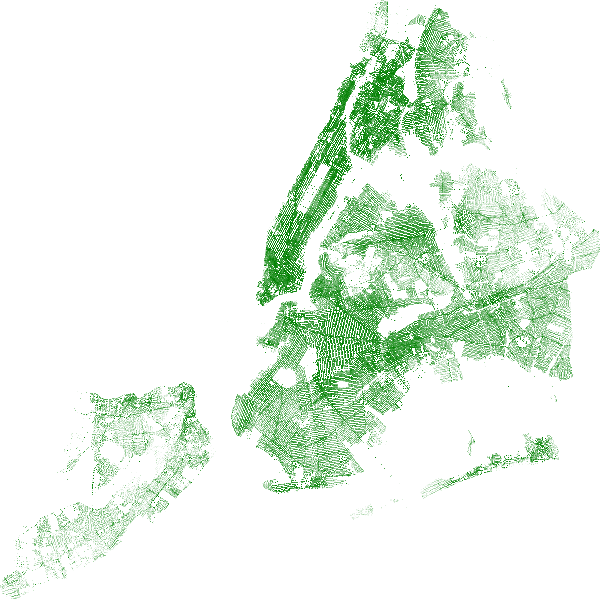

In [30]:
img

This is awesome, pretty much exactly what I was looking for! With this much data (similarly to datashader's [NYC Taxi]() and [2010 US Census]() visualizations, you can basically make out the geographical region _**without even plotting a map**_! You can even make out the street blocks, parks, and rivers / lakes. It looks like the most crime occurs in Manhattan, the Bronx, and East Brooklyn. I don't know too much more about NYC to be able to infer whether this is because of population, demographics, landmarks... etc, but this is definitely pointing me to the right direction. There's a few more things I want to do in datashader first before I dive any deeper into analysis, but this notebook is already getting pretty convoluted with the parquet loading and datashader installation, so let's start a fresh notebook for our datashader deep dive.